## Motif using logos in python using matplotlib

This is a proof of concept for plotting motif logos using matplotlib.
The coordinates for bases were picked of from [seqLogo](http://bioconductor.org/packages/release/bioc/html/seqLogo.html) package.

`seqLogo` is LGPL(v2.1) licensed and hence so is this notebook.

See [LICENCE](LICENSE)

In [1]:
%matplotlib inline
from __future__ import division
from Bio import motifs
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import transforms

colors_scheme = {'G': 'orange', 'A': 'red', 'C': 'blue', 'T': 'darkgreen'}


In [27]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc["ref_fa"]

import os

import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import motif_analysis
import helper
import create_output
print('Number of tissues: ',len(tissues))

import plot_tss_results
from scipy.stats import entropy
import motif_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
('Number of tissues: ', 13)


In [3]:
hum_ref_fa = '/data/isshamie/genome/hg38/GCF_000001405.38_GRCh38.p12_genomic.fna'

In [4]:
save_dir = "Results/motif_logos"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
exp_bed_f = "../Results/output/TSS1.exp.bed"
#mrna_bed_f = "../Results/Figures/Figure3/A.TSS1_mrna"
## Create RefSeq peak file for this
meta_f = "../Results/output/TSS1.exp.meta"
mrna_bed_f = os.path.join(save_dir, "TSS1.exp_refseq_centered.bed")

#mrna_filt = "Results/Figures/Figure3/A.mrna"
#create_output.exp_bed_to_refseq(exp_bed_f,meta_f,refseq_f=mRNA_peak_file,save_f=mrna_bed_f,is_unique=True)

annotatePeaks.pl ../Results/output/TSS1.exp.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 100 -hist 1 -di > Results/motif_logos/eTSS_100
annotatePeaks.pl Results/homer_motifs/TSS1.exp_refseq_centered.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 100 -hist 1 -di > Results/motif_logos/rTSS_100
annotatePeaks.pl /data/isshamie/genome/hg38/mRNA_final.peak /data/isshamie/genome/hg38/GCF_000001405.38_GRCh38.p12_genomic.fna -size 100 -hist 1 -di > Results/motif_logos/humTSS_100


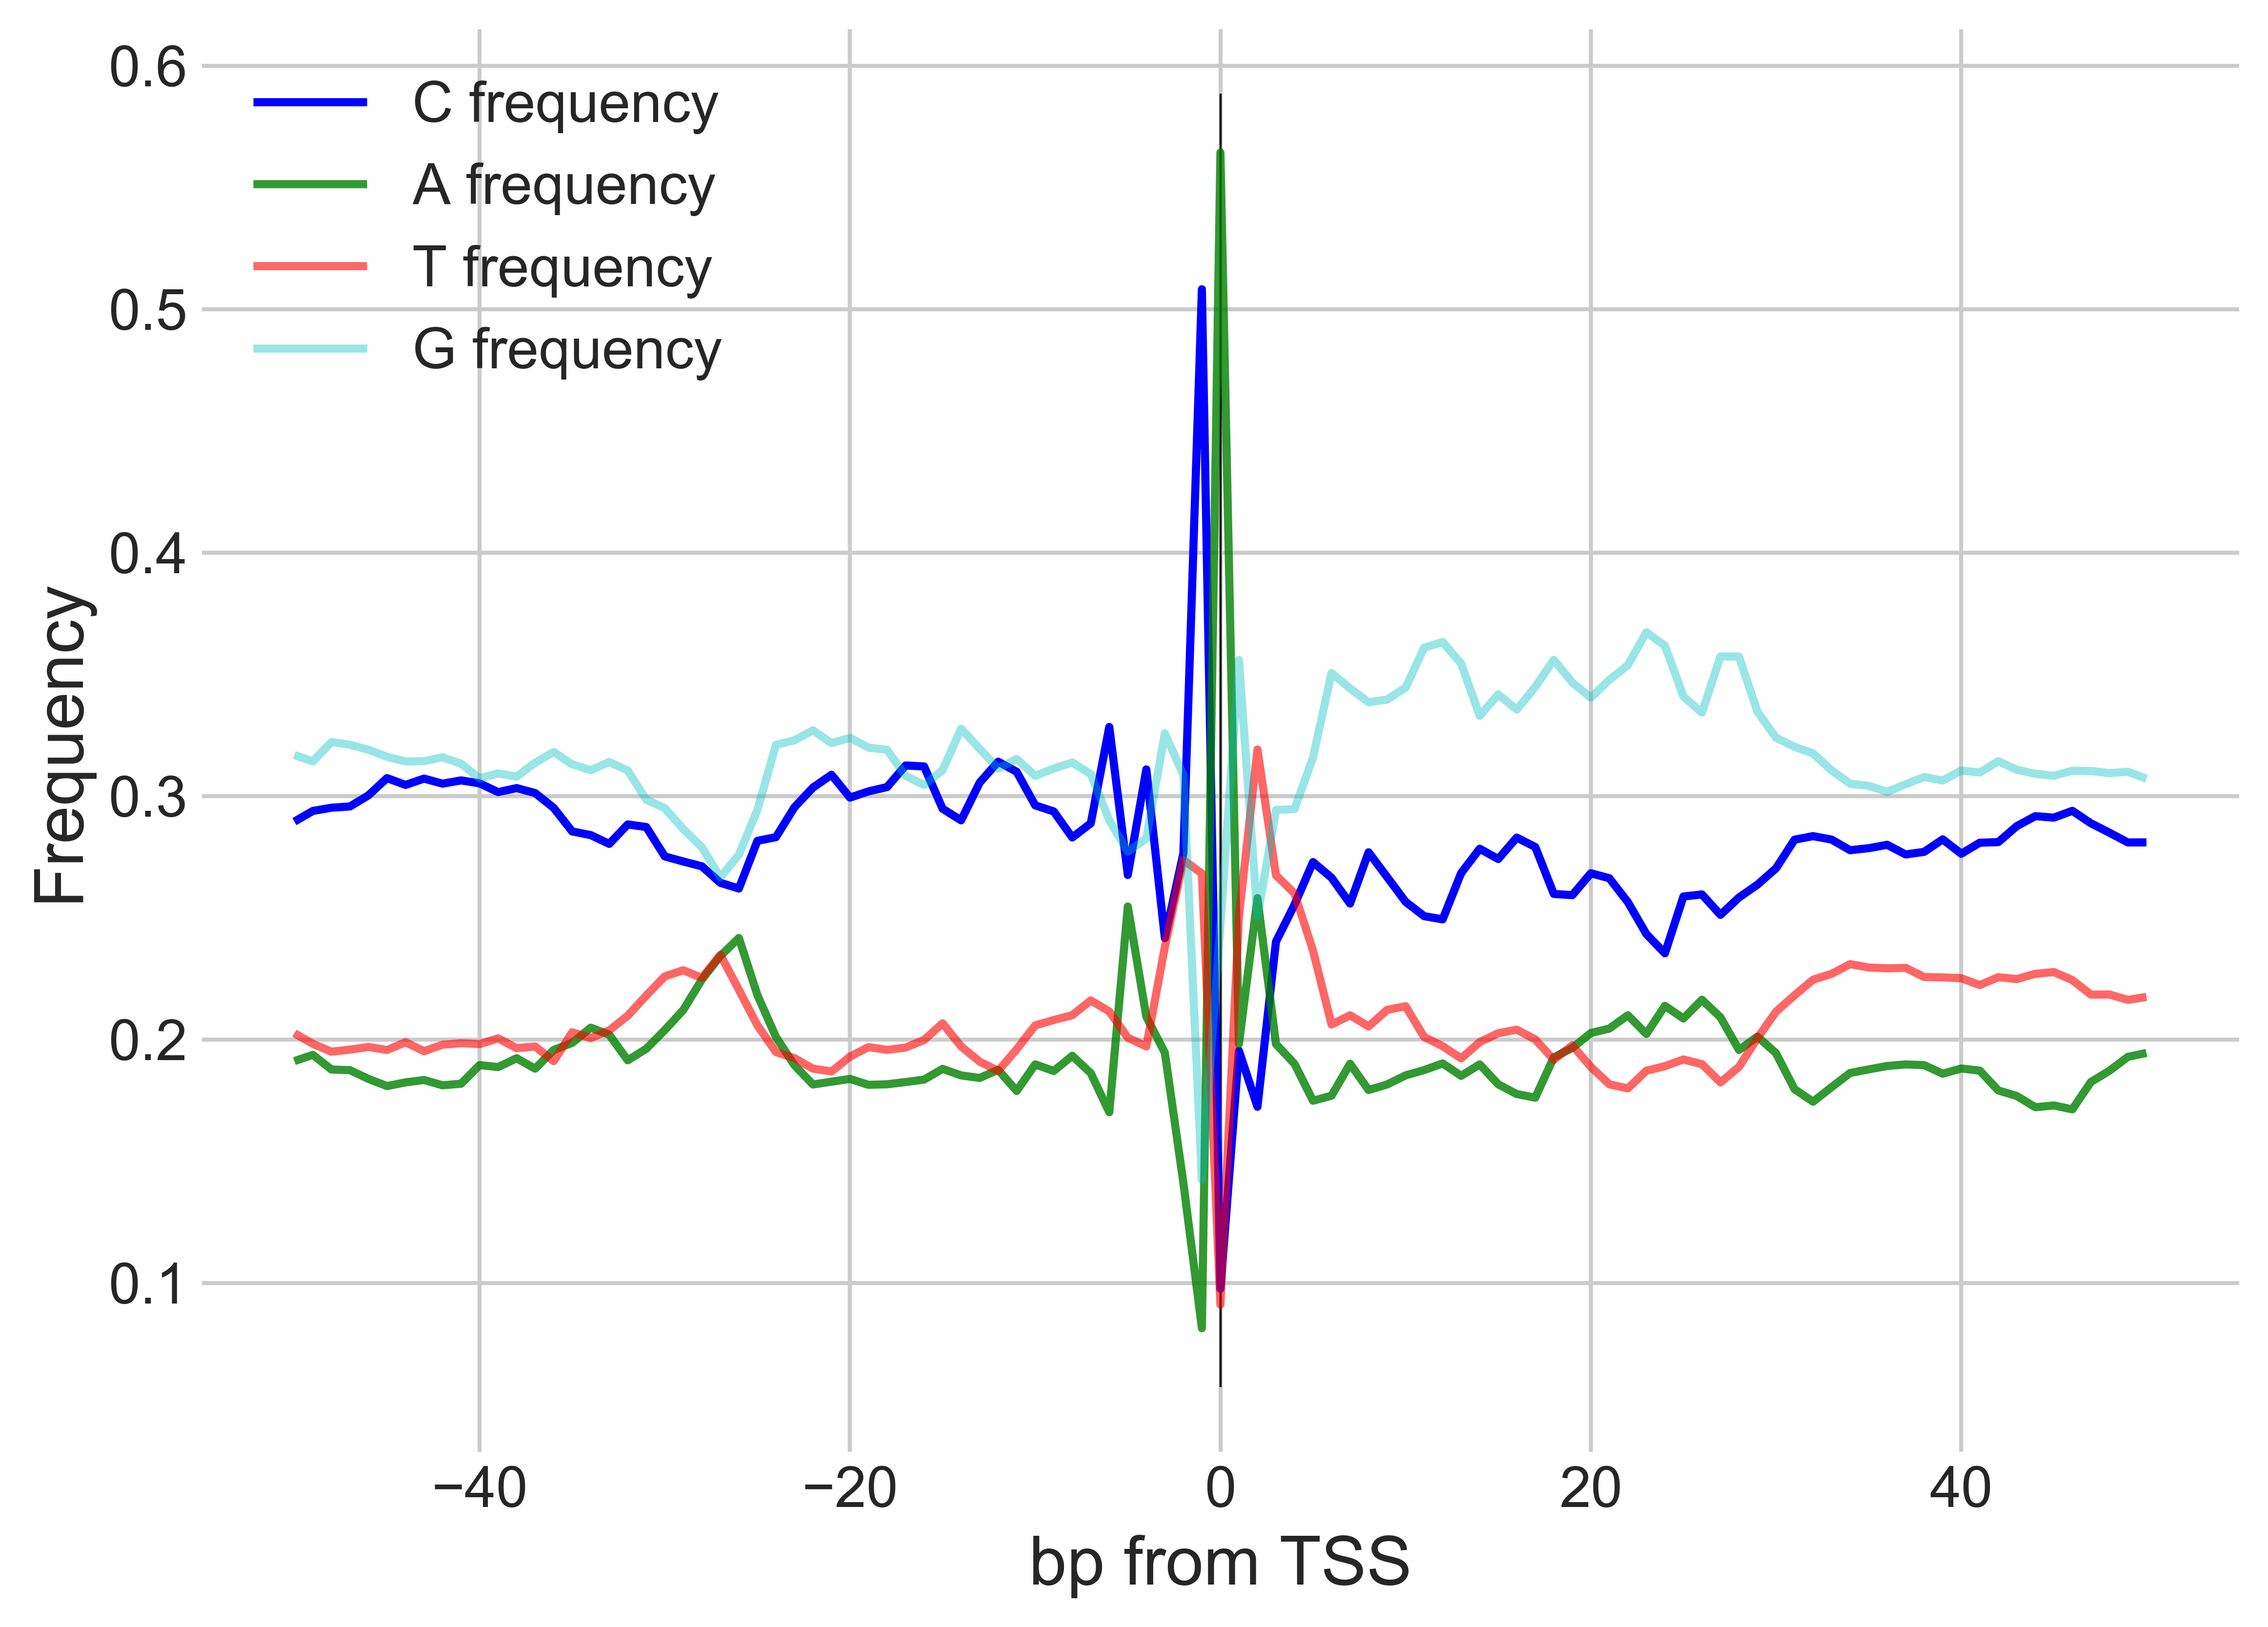

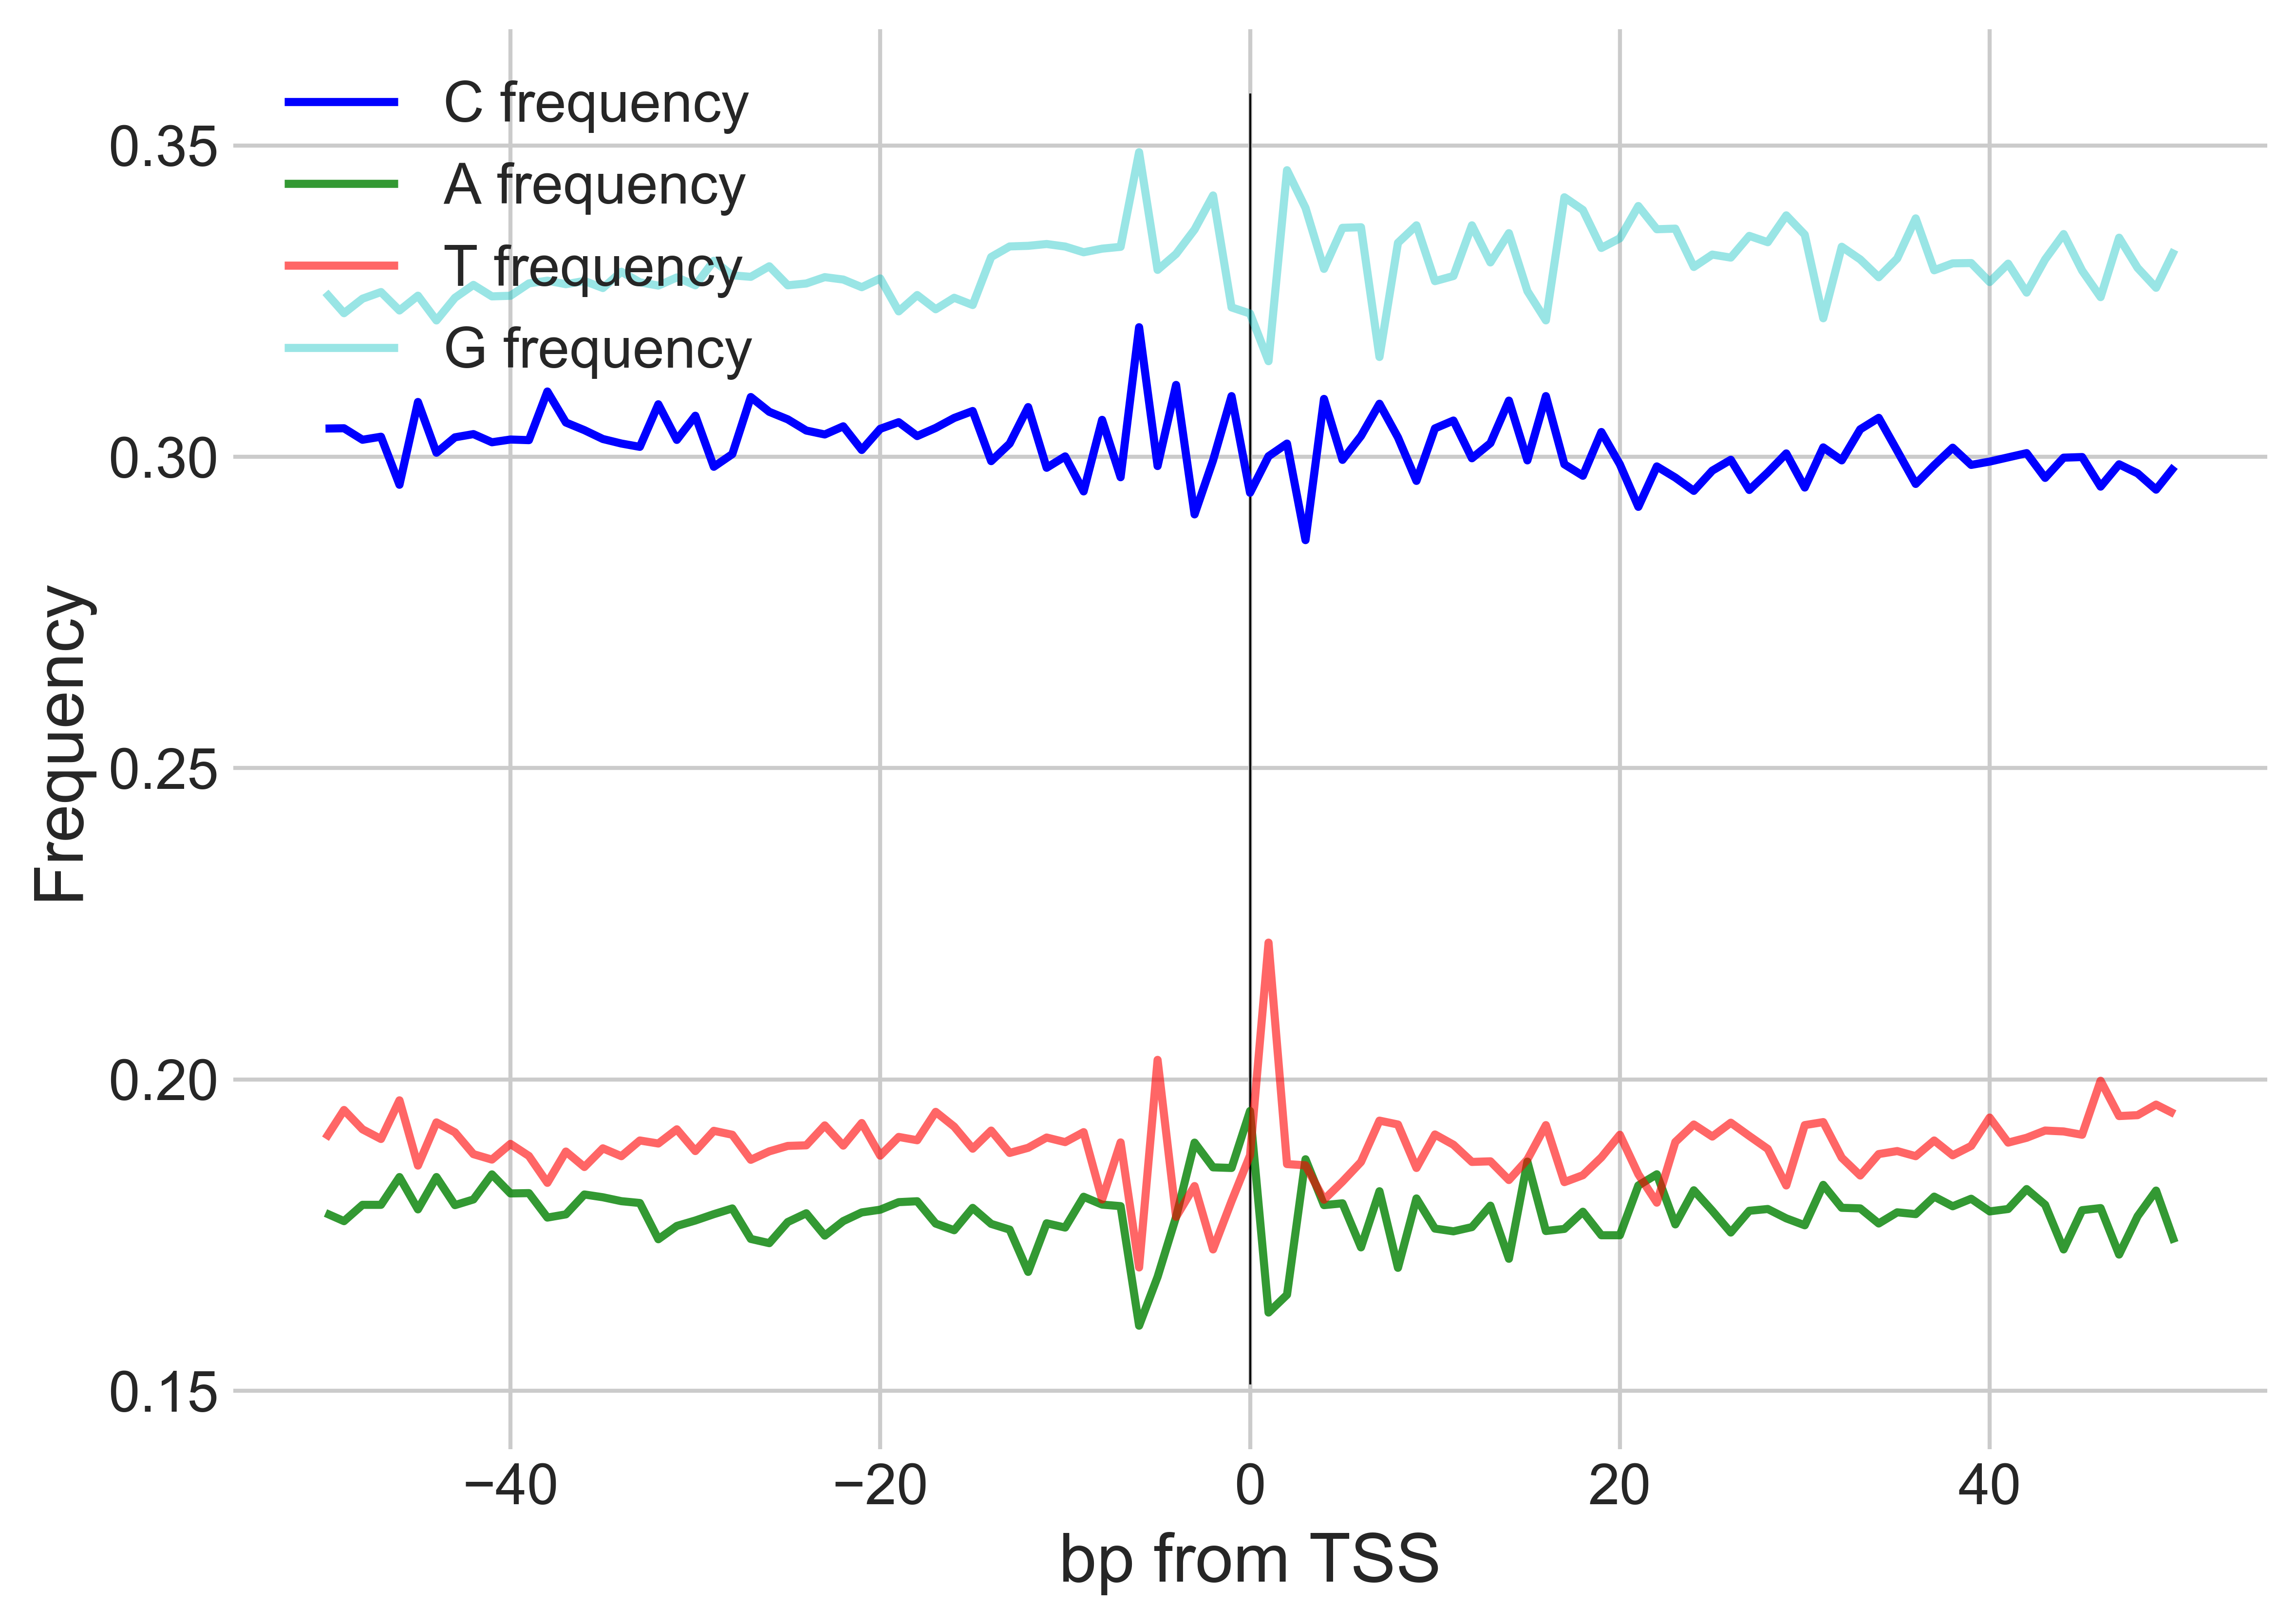

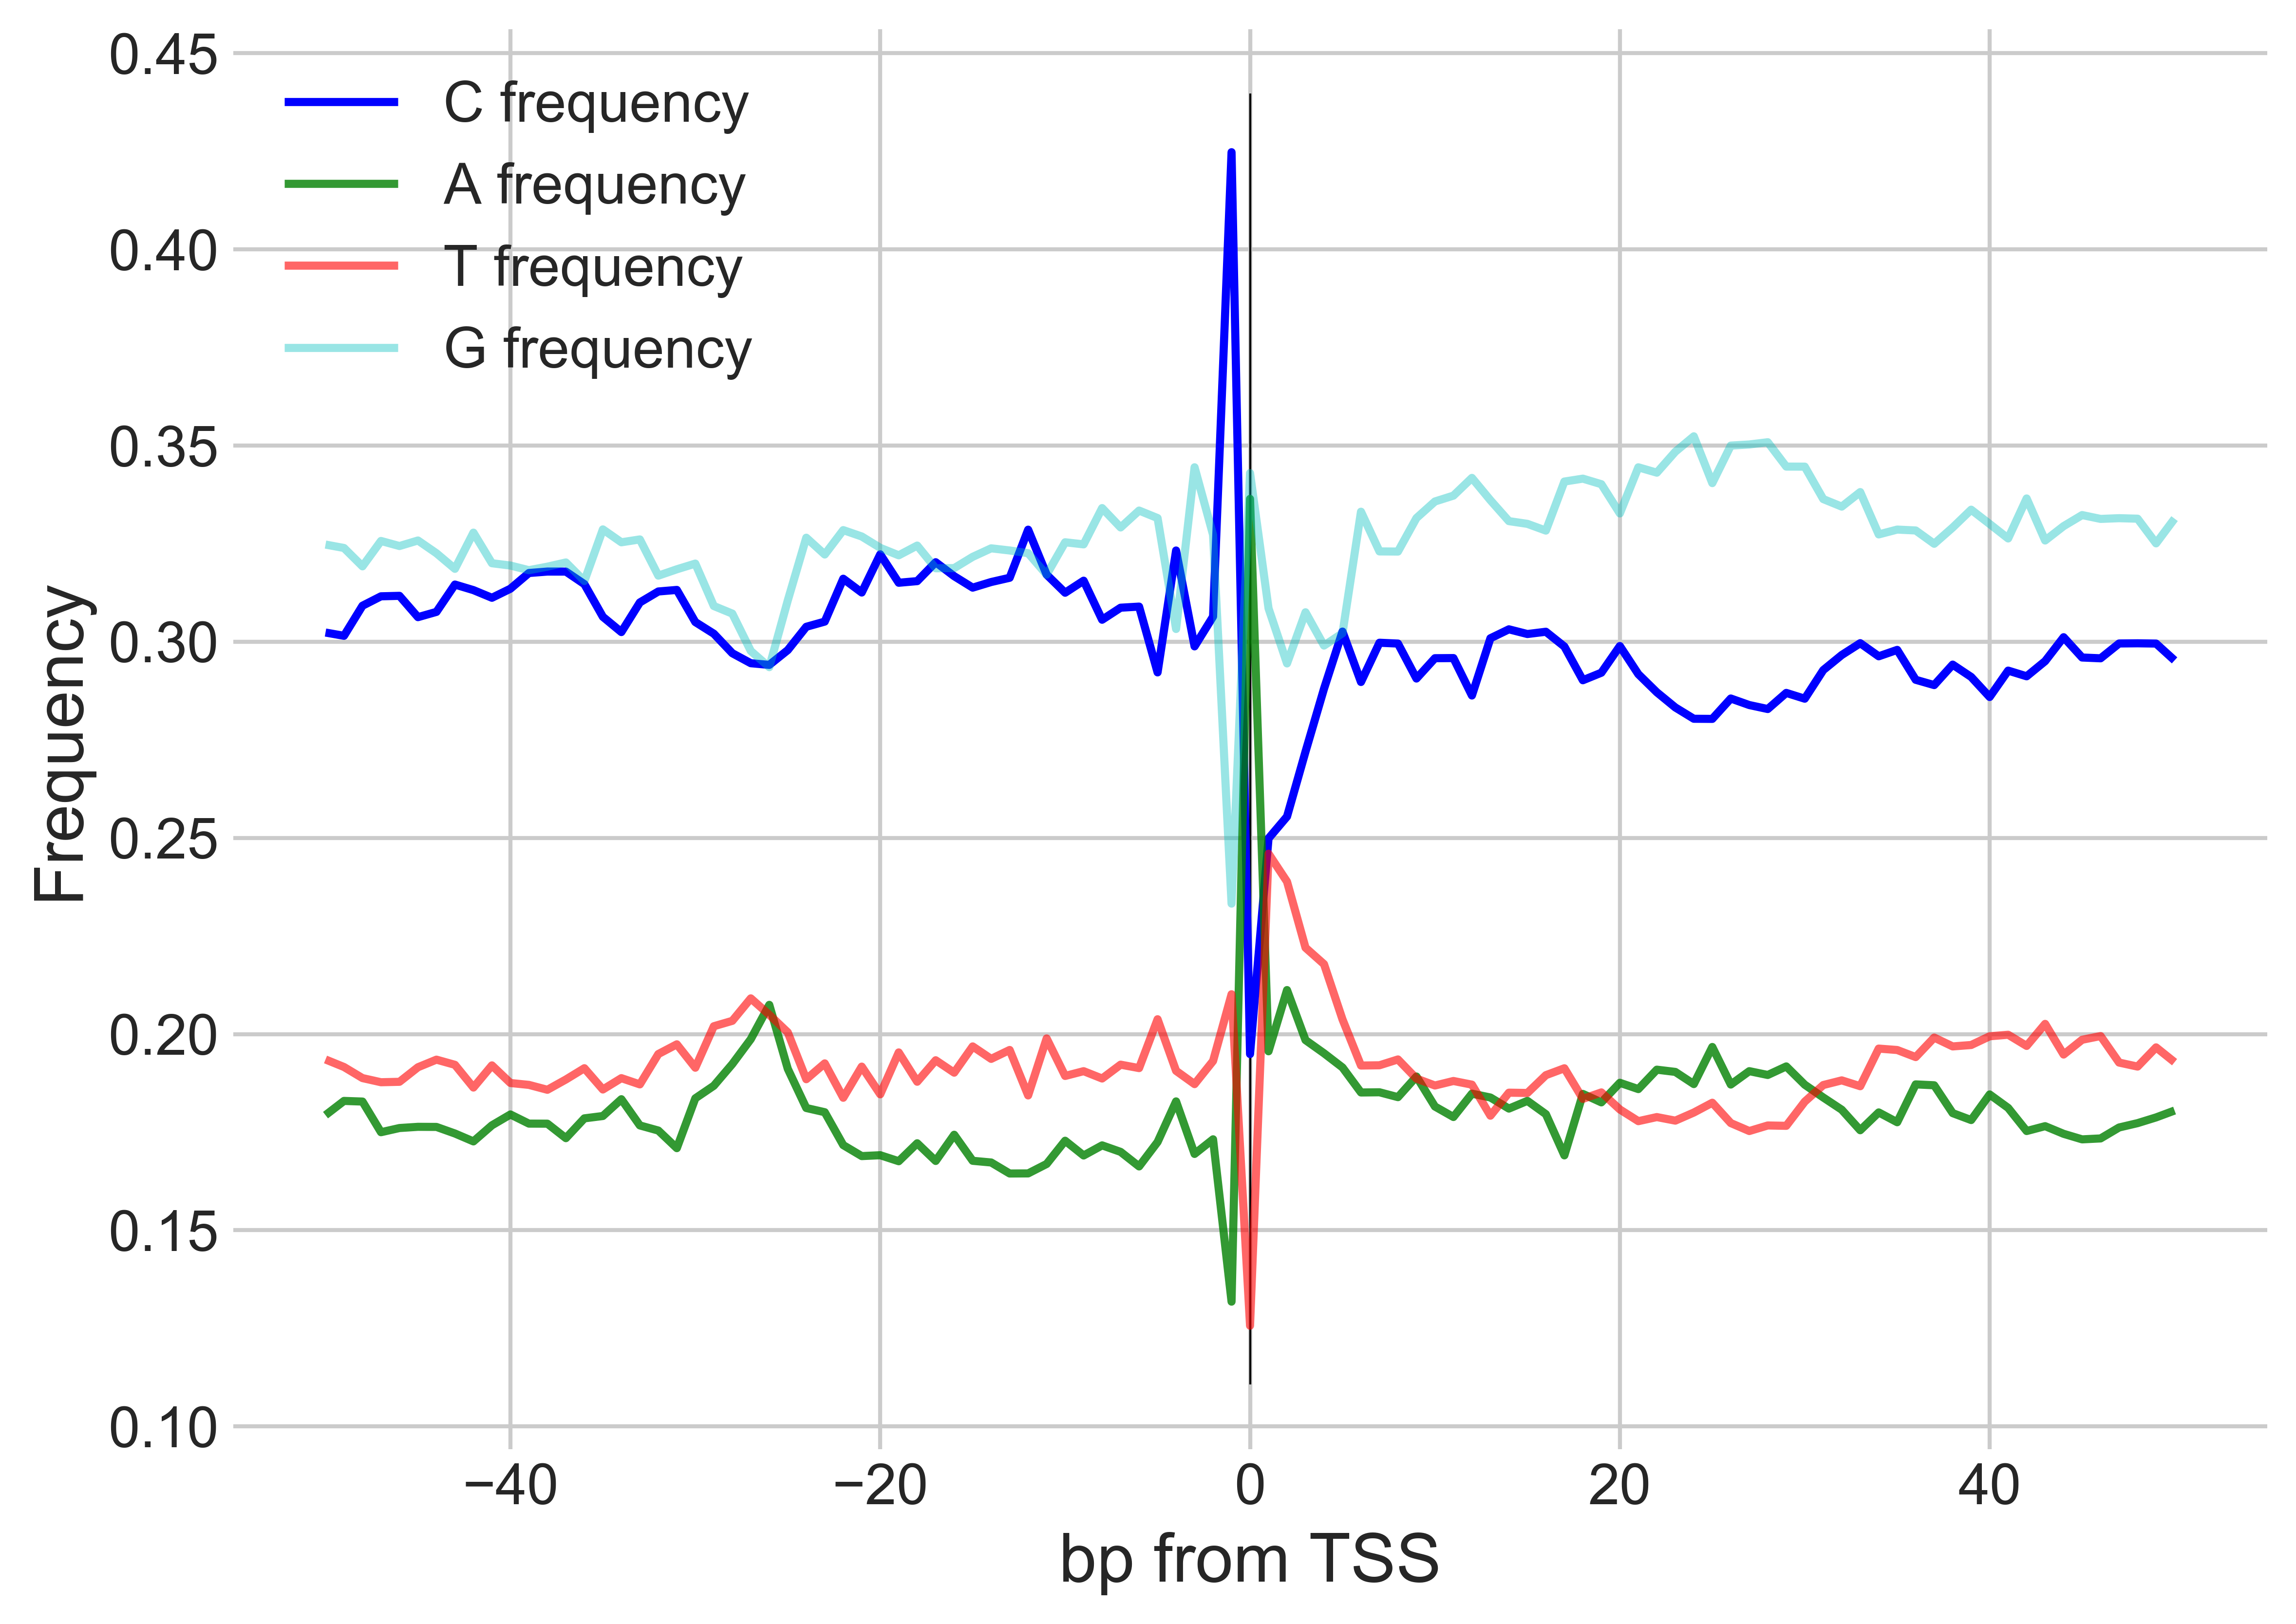

In [6]:
eTSS = "../Results/output/TSS1.exp.bed"
eTSS_out = os.path.join(save_dir, "eTSS_100")
homer_nucleotide(eTSS,
    eTSS_out,
    ref_fa,
    size=100)

rTSS = "Results/homer_motifs/TSS1.exp_refseq_centered.bed"
rTSS_out = os.path.join(save_dir, "rTSS_100")
homer_nucleotide(rTSS,
    rTSS_out,
    ref_fa,
    size=100)

humTSS = "/data/isshamie/genome/hg38/mRNA_final.peak"
humTSS_out = os.path.join(save_dir, "humTSS_100")

homer_nucleotide(humTSS,
    humTSS_out,
    hum_ref_fa,
    size=100)

In [7]:
#ACGT
def setup_as_motif(f_in, f_save,ind_range=(-10, 10) , is_bg= True, is_info = True):
    #n is number of sequences used
    m = pd.read_csv(f_in, sep="\t", index_col=0)
    m = m[["A frequency", "C frequency","G frequency","T frequency"]]
    
    # Generate background file
    nucs = m.sum()
    tot = nucs.sum()
    bg = {"A": nucs["A frequency"]/tot, "C": nucs["C frequency"]/tot, "G":nucs["G frequency"]/tot, "T":nucs["T frequency"]/tot }
    bg = pd.Series(bg)
    bg.index = bg.index.rename("#\torder 0")
    bg.to_csv("tmp_motif.bg",sep="\t",header=True)
    
    #Restrict m to the index range
    m = m.loc[ind_range[0]:ind_range[1]].transpose()  

    # tmp files for storing motifs
    tmp_pfm = "tmp_motif.pfm"
    tmp = "tmp_motif.meme" 
    
    # normalize m to the background frequencies
    if is_bg:
        m.loc["A frequency"] = m.loc["A frequency"]/bg["A"]
        m.loc["C frequency"] = m.loc["C frequency"]/bg["C"]
        m.loc["G frequency"] = m.loc["G frequency"]/bg["G"]
        m.loc["T frequency"] = m.loc["T frequency"]/bg["T"]
        # Re-normalize
        m = m/m.sum() 
        cmd = "jaspar2meme -bg tmp_motif.bg -pfm . > %s" % tmp #-logodds
    else:
        cmd = "jaspar2meme -pfm . > %s" % tmp 
        
    m.to_csv(tmp_pfm,sep="\t",header=None,index=None)
    !{cmd}
    
    
    # Generate seq logo    
    cmd_png = "ceqlogo -i %s -m 1 -p 0 -c 0.25 -o %s -f PNG" % (tmp, f_save + ".png")
    cmd_eps = "ceqlogo -i %s -m 1 -p 0 -c 0.25 -o %s -f EPS" % (tmp, f_save + ".eps")

    #This scales each position to 1
    if not is_info:
        cmd_png = cmd_png + " -F"
        cmd_eps = cmd_eps + " -F"
        
    !{cmd_png}
    !{cmd_eps}
    
    cmd = "rm %s %s" % (tmp, tmp_pfm)
    !{cmd}
    
    return m, bg

## Input is Nucleotides

In [11]:
f_in = rTSS_out#"Results/Figures/Figure3/alt/C_i_exp.nuc_freq_1000.txt"
f_save = os.path.join(save_dir,"C_exp_m10_10_bg")
ind_range=(-40, -15)
is_bg=True
is_info=False


m = pd.read_csv(f_in, sep="\t", index_col=0)
m = m[["A frequency", "C frequency","G frequency","T frequency"]]

# Generate background file
nucs = m.sum()
tot = nucs.sum()
bg = {"A": nucs["A frequency"]/tot, "C": nucs["C frequency"]/tot, "G":nucs["G frequency"]/tot, "T":nucs["T frequency"]/tot }
bg = pd.Series(bg)
bg.index = bg.index.rename("#\torder 0")
bg.to_csv("tmp_motif.bg",sep="\t",header=True)

#Restrict m to the index range
m = m.loc[ind_range[0]:ind_range[1]].transpose()  

# tmp files for storing motifs
tmp_pfm = "tmp_motif.pfm"
tmp = "tmp_motif.meme"

# # normalize m to the background frequencies
# if is_bg:
m.loc["A frequency"] = m.loc["A frequency"]/bg["A"]
m.loc["C frequency"] = m.loc["C frequency"]/bg["C"]
m.loc["G frequency"] = m.loc["G frequency"]/bg["G"]
m.loc["T frequency"] = m.loc["T frequency"]/bg["T"]
# Re-normalize
m = m/m.sum() 
#     cmd = "jaspar2meme -bg tmp_motif.bg -pfm . > %s" % tmp #-logodds
# else:
#     cmd = "jaspar2meme -pfm . > %s" % tmp 


In [16]:
f_in = eTSS_out

#Inr region
## with bg, without info_content
m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"exp_m4_3_bg"),
    ind_range=(-4, 3),
    is_bg=True,
    is_info=False)



## without bg, without info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"exp_m4_3_nobg"),
    ind_range=(-4, 3), 
    is_info=False,
    is_bg=False)


## without bg, with info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"exp_m4_3_nobg_info"),
    ind_range=(-4, 3),
    is_info=True,
    is_bg=False)

## with bg, with info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"exp_m4_3_info"),
    ind_range=(-4, 3),
    is_info=True,
    is_bg=True)


In [17]:
f_in = rTSS_out

#Inr region
## with bg, without info_content
m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"ref_m4_3_bg"),
    ind_range=(-4, 3),
    is_bg=True,
    is_info=False)



## without bg, without info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"ref_m4_3_nobg"),
    ind_range=(-4, 3), 
    is_info=False,
    is_bg=False)


## without bg, with info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"ref_m4_3_nobg_info"),
    ind_range=(-4, 3),
    is_info=True,
    is_bg=False)

## with bg, with info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"ref_m4_3_info"),
    ind_range=(-4, 3),
    is_info=True,
    is_bg=True)


In [18]:
f_in = humTSS_out

#Inr region
## with bg, without info_content
m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"hg38_m4_3_bg"),
    ind_range=(-4, 3),
    is_bg=True,
    is_info=False)



## without bg, without info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"hg38_m4_3_nobg"),
    ind_range=(-4, 3), 
    is_info=False,
    is_bg=False)


## without bg, with info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"hg38_m4_3_nobg_info"),
    ind_range=(-4, 3),
    is_info=True,
    is_bg=False)

## with bg, with info_content

#Inr region

m = setup_as_motif(
    f_in,
    f_save=os.path.join(save_dir,"hg38_m4_3_info"),
    ind_range=(-4, 3),
    is_info=True,
    is_bg=True)


### Height calculation near tata

In [25]:
# A and T freq change 0.23/0.2 

#G and C freq change 0.27/0.3

# total for renorm: 2*0.9+ 1.15*2

# p = np.array([0.23/0.2,0.23/0.2,0.27/0.3,0.27/0.3])/(2*0.9+ 1.15*2)
# print("Normed probability vector", p)


# print("IC", 2 - entropy(p,base=2))

### Calculate pointwise entropy calculation

In [19]:
m = pd.read_csv(f_in, sep="\t", index_col=0)
m = m[["A frequency", "C frequency","G frequency","T frequency"]]
m =(m.apply(lambda x: x/x.sum(),axis=1))
m

,A frequency,C frequency,G frequency,T frequency
Distance from Center (cmd=annotatePeaks.pl /data/isshamie/genome/hg38/mRNA_final.peak /data/isshamie/genome/hg38/GCF_000001405.38_GRCh38.p12_genomic.fna -size 100 -hist 1 -di),,,,
-50,0.179346,0.302348,0.324771,0.193535
-49,0.182969,0.301518,0.323899,0.191614
-48,0.182809,0.309182,0.319220,0.188788
-47,0.174995,0.311583,0.325688,0.187733
-46,0.176060,0.311701,0.324397,0.187842
-45,0.176367,0.306270,0.325809,0.191554
-44,0.176342,0.307612,0.322555,0.193491
-43,0.174664,0.314578,0.318586,0.192173
-42,0.172651,0.313160,0.327810,0.186378


In [32]:
def plot_entropy(f_in1, f_in2, f_save=None,ind_range=(-10, 10), is_bg= True, labels=None):
    #n is number of sequences used
    m = pd.read_csv(f_in1, sep="\t", index_col=0)
    m = m[["A frequency", "C frequency","G frequency","T frequency"]]
    m = m.apply(lambda x: x/x.sum(),axis=1)
    m["IC"] = m.apply(lambda x: 2 -  entropy(x),axis=1)
    
    m2 = pd.read_csv(f_in2, sep="\t", index_col=0)
    m2 = m2[["A frequency", "C frequency","G frequency","T frequency"]]
    m2 = m2.apply(lambda x: x/x.sum(),axis=1)
    m2["IC"] = m2.apply(lambda x: 2 -  entropy(x),axis=1)
        
    # Plot
    f = plt.figure()
    plt.plot(m["IC"])
    plt.plot(m2["IC"],c='g')
    plt.ylabel("Information Content (2-entropy)")
    plt.xlabel("Nucleotide position relative to TSS")

    if labels is not None:
        plt.legend(labels)
    helper_save(f_save)
    
    
#     #--------
#     # Generate background file
#     nucs = m.sum()
#     tot = nucs.sum()
#     bg = {"A": nucs["A frequency"]/tot, "C": nucs["C frequency"]/tot, "G":nucs["G frequency"]/tot, "T":nucs["T frequency"]/tot }
#     bg = pd.Series(bg)
#     bg.index = bg.index.rename("#\torder 0")
#     bg.to_csv("tmp_motif.bg",sep="\t",header=True)
    
#     #Restrict m to the index range
#     m = m.loc[ind_range[0]:ind_range[1]].transpose()  
    return m,m2

    

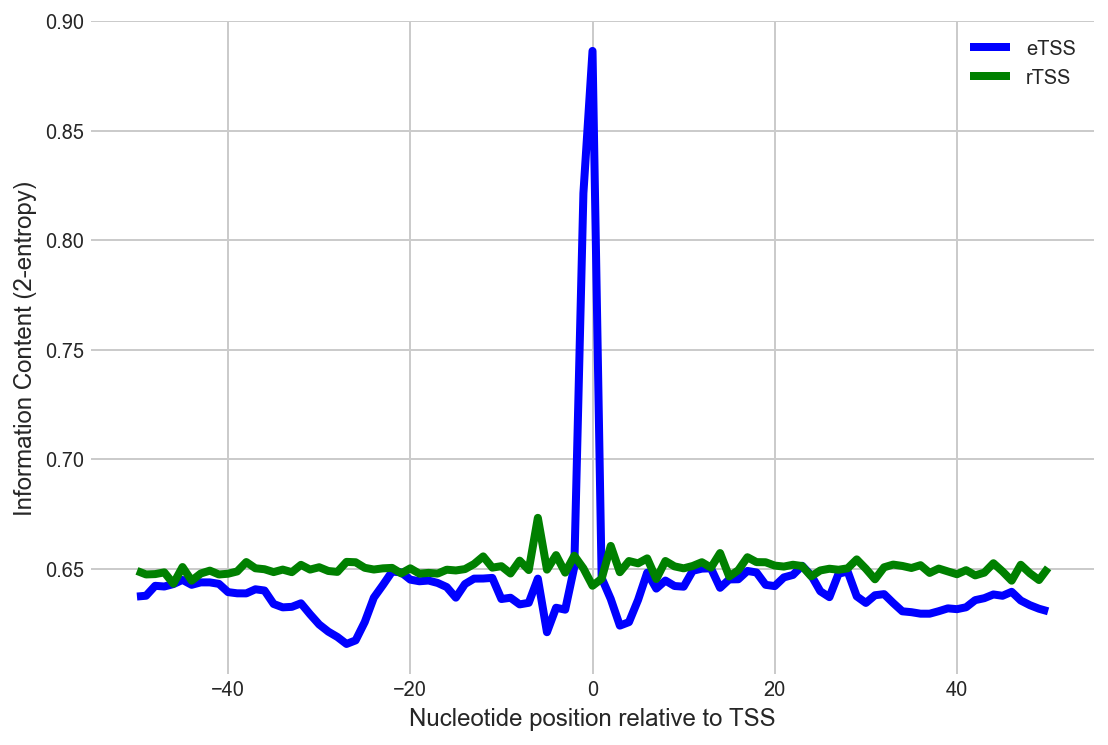

In [33]:
f_in1 = os.path.join(save_dir,"C_i_exp.nuc_freq_200.txt")
f_in2 = os.path.join(save_dir,"C_i_refseq.nuc_freq_200.txt")
_ = plot_entropy(eTSS_out, rTSS_out,f_save=os.path.join(save_dir,"IC"), labels=["eTSS", "rTSS"])
